# The JAX emulator: CIGALE prototype
In this notebook, I will prototype my idea for emulating radiative transfer codes with a Deepnet in order for it to be used inside xidplus. As `numpyro` uses JAX, the Deepnet wil ideally be trained with a JAX network. I will use CIGALE

In [1]:

from astropy.cosmology import WMAP9 as cosmo
import jax
import numpy as onp
import pylab as plt
import astropy.units as u
import scipy.integrate as integrate
%matplotlib inline

import jax.numpy as np
from jax import grad, jit, vmap, value_and_grad
from jax import random
from jax import vmap # for auto-vectorizing functions
from functools import partial # for use with vmap
from jax import jit # for compiling functions for speedup
from jax.experimental import stax # neural network library
from jax.experimental.stax import Conv, Dense, MaxPool, Relu, Flatten, LogSoftmax, LeakyRelu # neural network layers

from jax.experimental import optimizers
from jax.tree_util import tree_multimap  # Element-wise manipulation of collections of numpy arrays 
import matplotlib.pyplot as plt # visualization
# Generate key which is used to generate random numbers
key = random.PRNGKey(1)

W0329 11:48:54.943562 4378119616 xla_bridge.py:135] No GPU/TPU found, falling back to CPU. (Set TF_CPP_MIN_LOG_LEVEL=0 and rerun for more info.)


### Read in CIGALE SEDs

In [2]:
from astropy.io import fits
from astropy.table import Table

/Users/pdh21/anaconda3/envs/xidplus/lib/python3.6/site-packages/dask/config.py:168: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  data = yaml.load(f.read()) or {}


### Generate values for CIGALE

Redshift

In [3]:
onp.array2string(10.0**np.arange(-2.5,0.77,0.02), separator=',',formatter={'float_kind':lambda x: "%.4f" % x}).replace('\n','')

'[0.0032,0.0033,0.0035,0.0036,0.0038,0.0040,0.0042,0.0044,0.0046,0.0048, 0.0050,0.0052,0.0055,0.0058,0.0060,0.0063,0.0066,0.0069,0.0072,0.0076, 0.0079,0.0083,0.0087,0.0091,0.0095,0.0100,0.0105,0.0110,0.0115,0.0120, 0.0126,0.0132,0.0138,0.0145,0.0151,0.0158,0.0166,0.0174,0.0182,0.0191, 0.0200,0.0209,0.0219,0.0229,0.0240,0.0251,0.0263,0.0275,0.0288,0.0302, 0.0316,0.0331,0.0347,0.0363,0.0380,0.0398,0.0417,0.0437,0.0457,0.0479, 0.0501,0.0525,0.0550,0.0575,0.0603,0.0631,0.0661,0.0692,0.0724,0.0759, 0.0794,0.0832,0.0871,0.0912,0.0955,0.1000,0.1047,0.1096,0.1148,0.1202, 0.1259,0.1318,0.1380,0.1445,0.1514,0.1585,0.1660,0.1738,0.1820,0.1905, 0.1995,0.2089,0.2188,0.2291,0.2399,0.2512,0.2630,0.2754,0.2884,0.3020, 0.3162,0.3311,0.3467,0.3631,0.3802,0.3981,0.4169,0.4365,0.4571,0.4786, 0.5012,0.5248,0.5495,0.5754,0.6026,0.6310,0.6607,0.6918,0.7244,0.7586, 0.7943,0.8318,0.8710,0.9120,0.9550,1.0000,1.0471,1.0965,1.1481,1.2023, 1.2589,1.3182,1.3804,1.4454,1.5136,1.5849,1.6596,1.7378,1.8197,1.9054, 1.99

AGN frac

In [4]:
onp.array2string(np.arange(0.001,1,0.05),separator=',',formatter={'float_kind':lambda x: "%.3f" % x}).replace('\n','')

'[0.001,0.051,0.101,0.151,0.201,0.251,0.301,0.351,0.401,0.451,0.501,0.551, 0.601,0.651,0.701,0.751,0.801,0.851,0.901,0.951]'

In [5]:
SEDs=Table.read('/Volumes/pdh_storage/cigale/2021-03-15_11:52:42_out//models-block-0.fits')
#set more appropriate units for dust
from astropy.constants import L_sun, M_sun
SEDs['dust.luminosity']=SEDs['dust.luminosity']/L_sun.value
SEDs['dust.mass']=SEDs['dust.mass']/M_sun.value

In [6]:
SEDs

id,IRAC1,megacam_g,megacam_i,megacam_r,megacam_u,megacam_y,megacam_z,mips_24,spire_250,spire_350,spire_500,dust.luminosity,dust.mass,sfh.sfr,stellar.m_star,agn.fracAGN,attenuation.BC_to_ISM_factor,attenuation.bessell_b,attenuation.galex_fuv,attenuation.slope_BC,attenuation.slope_ISM,dust.qpah,dust.umin,sfh.age,sfh.burst_age,sfh.f_burst,sfh.tau_main,universe.redshift
,mJy,mJy,mJy,mJy,mJy,mJy,mJy,mJy,mJy,mJy,mJy,W,kg,solMass / yr,solMass,,,mag,mag,mag,,,,Myr,,,,
int64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64
0,1.0893700290160224e-07,4.277375681543152e-09,1.1824289763043319e-08,7.798121660412185e-09,1.777989256103348e-09,1.2304162230857001e-08,1.7054977663496222e-08,6.193894640285195e-06,2.8612034146739133e-05,1.0897664019213495e-05,3.688584055077046e-06,31.99616305125483,0.017176376845766003,3.6011411610560557e-09,0.6968899218426298,0.001,0.5,4.376290746740257,9.392077535240679,-0.7,-0.7,1.12,10.0,1000.0,50.0,0.1,3000.0,0.0032
1,1.0242388186338501e-07,4.020819062006951e-09,1.1115475041403518e-08,7.330602680929944e-09,1.6708763677153773e-09,1.1566603330970226e-08,1.603232961482222e-08,5.822685333049485e-06,2.6909489755942493e-05,1.0249702314812148e-05,3.4693157070610693e-06,31.99616305125483,0.017176376845766003,3.6011411610560557e-09,0.6968899218426298,0.001,0.5,4.376290746740257,9.392077535240679,-0.7,-0.7,1.12,10.0,1000.0,50.0,0.1,3000.0,0.0033
2,9.103331341237172e-08,3.572206200057256e-09,9.876011063757583e-09,6.5130826736568e-09,1.48361591749095e-09,1.0276885920014647e-08,1.4244115301572681e-08,5.1735662520352136e-06,2.393130041728951e-05,9.116212348847797e-06,3.085747125013702e-06,31.99616305125483,0.017176376845766003,3.6011411610560557e-09,0.6968899218426298,0.001,0.5,4.376290746740257,9.392077535240679,-0.7,-0.7,1.12,10.0,1000.0,50.0,0.1,3000.0,0.0035
3,8.603695555130602e-08,3.375458310331776e-09,9.332402750385152e-09,6.1545343301667955e-09,1.4015056082316665e-09,9.711248577067663e-09,1.345985243913158e-08,4.888870982525272e-06,2.2624649968682522e-05,8.618886214220273e-06,2.917452516854994e-06,31.99616305125483,0.017176376845766003,3.6011411610560557e-09,0.6968899218426298,0.001,0.5,4.376290746740257,9.392077535240679,-0.7,-0.7,1.12,10.0,1000.0,50.0,0.1,3000.0,0.0036
4,7.720224011090768e-08,3.0276169197564973e-09,8.371299045028442e-09,5.5206214705437795e-09,1.2563664915318932e-09,8.711188231930118e-09,1.2073283452326269e-08,4.385522855293602e-06,2.0313677765421176e-05,7.73927071340886e-06,2.6197886321423186e-06,31.99616305125483,0.017176376845766003,3.6011411610560557e-09,0.6968899218426298,0.001,0.5,4.376290746740257,9.392077535240679,-0.7,-0.7,1.12,10.0,1000.0,50.0,0.1,3000.0,0.0038
5,6.966009367077697e-08,2.730729067588272e-09,7.550948717424769e-09,4.97954934592474e-09,1.1325206490784163e-09,7.857580832698825e-09,1.0889796399841026e-08,3.955884844794926e-06,1.8340219367195694e-05,6.98808653322697e-06,2.365581872817584e-06,31.99616305125483,0.017176376845766003,3.6011411610560557e-09,0.6968899218426298,0.001,0.5,4.376290746740257,9.392077535240679,-0.7,-0.7,1.12,10.0,1000.0,50.0,0.1,3000.0,0.004
6,6.317018702931238e-08,2.475315756565785e-09,6.8451710603252375e-09,4.514048265490808e-09,1.0260038246653045e-09,7.123185495475755e-09,9.871614286975135e-09,3.586246619708091e-06,1.664158005457788e-05,6.341484278810178e-06,2.1467622116579716e-06,31.99616305125483,0.017176376845766003,3.6011411610560557e-09,0.6968899218426298,0.001,0.5,4.376290746740257,9.392077535240679,-0.7,-0.7,1.12,10.0,1000.0,50.0,0.1,3000.0,0.0042
7,5.7545919268305324e-08,2.2540032478313774e-09,6.233600384418341e-09,4.110684648219867e-09,9.337326149269411e-10,6.486818450129212e-09,8.989350000898116e-09,3.2659426120459205e-06,1.5168985902744644e-05,5.7808977976512035e-06,1.9570486761070138e-06,31.99616305125483,0.017176376845766003,3.6011411610560557e-09,0.6968899218426298,0.0

In [7]:
from astropy.table import vstack

In [8]:
# define a range of scales
scale=np.arange(8,14,0.1)
#repeat the SED table by the number of scale steps
dataset=vstack([SEDs for i in range(0,scale.size)])
#repeat the scale range by the number of entries in table (so I can easily multiply each column)
scale_table=np.repeat(scale,len(SEDs))
#parameters to scale
col_scale=['megacam_u','megacam_g','megacam_r','megacam_i','megacam_z','megacam_y','IRAC1','mips_24','spire_250','spire_350','spire_500','dust.luminosity','dust.mass','sfh.sfr','stellar.m_star']
for c in col_scale:
    dataset[c]=dataset[c]*10.0**scale_table
dataset['log10_sfh.sfr']=onp.log10(dataset['sfh.sfr'])
dataset['log10_universe.redshift']=onp.log10(dataset['universe.redshift'])
# transform AGN fraction to logit scale
dataset['logit_agnfrac']=onp.log(dataset['agn.fracAGN']/(1-dataset['agn.fracAGN']))
#shuffle dataset
dataset=dataset[onp.random.choice(len(dataset), len(dataset), replace=False)]

In [9]:
dataset


id,IRAC1,megacam_g,megacam_i,megacam_r,megacam_u,megacam_y,megacam_z,mips_24,spire_250,spire_350,spire_500,dust.luminosity,dust.mass,sfh.sfr,stellar.m_star,agn.fracAGN,attenuation.BC_to_ISM_factor,attenuation.bessell_b,attenuation.galex_fuv,attenuation.slope_BC,attenuation.slope_ISM,dust.qpah,dust.umin,sfh.age,sfh.burst_age,sfh.f_burst,sfh.tau_main,universe.redshift,log10_sfh.sfr,log10_universe.redshift,logit_agnfrac
,,,,,,,,,,,,,,,,,,mag,mag,mag,,,,Myr,,,,,,,
int64,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float32,float64,float64
998,21526.705,48.02345,133.16199,87.659485,19.798983,138.61717,193.06714,129904.734,326071.84,124340.984,42101.63,1273819200000.0,683819460.0,143.36728,27744322000.0,0.301,0.5,4.376290746740257,9.392077535240679,-0.7,-0.7,1.12,10.0,1000.0,50.0,0.1,3000.0,0.006,2.15645,-2.221848749616356,-0.8425404774849347
343,932520.94,6896.9307,19096.502,12586.322,2841.0068,19874.639,27570.469,12247261.0,46870840.0,17878254.0,6054085.0,201890660000000.0,108380185000.0,22722.623,4397263700000.0,0.101,0.5,4.376290746740257,9.392077535240679,-0.7,-0.7,1.12,10.0,1000.0,50.0,0.1,3000.0,0.0063,4.3564587,-2.2006594505464183,-2.1861625176303607
3009,37639.785,4.047929,11.705162,7.529493,1.4664596,12.276423,18.235569,119831.77,33696.062,13044.643,4436.5527,6384259000000.0,3427237000.0,718.54297,139051860000.0,0.901,0.5,4.376290746740257,9.392077535240679,-0.7,-0.7,1.12,10.0,1000.0,50.0,0.1,3000.0,0.0437,2.8564527,-1.359518563029578,2.2083854074737483
1118,0.014511614,2.6209274e-05,0.00015251724,7.477375e-05,7.1125914e-06,0.00016292649,0.00027154663,0.8720222,24.006418,20.503332,11.34645,2018871100000.0,1083782800.0,227.22223,43971863000.0,0.301,0.5,4.376290746740257,9.392077535240679,-0.7,-0.7,1.12,10.0,1000.0,50.0,0.1,3000.0,1.5136,2.3564508,0.18001111905771755,-0.8425404774849347
1096,0.0055717807,6.6169246e-06,3.9692863e-05,2.185246e-05,2.7179406e-06,4.1389707e-05,5.793417e-05,0.050276194,0.64440656,0.323867,0.12669584,10118119000.0,5431671.0,1.1387858,220376910.0,0.301,0.5,4.376290746740257,9.392077535240679,-0.7,-0.7,1.12,10.0,1000.0,50.0,0.1,3000.0,0.5495,0.05644206,-0.26003230324049065,-0.8425404774849347
87,1.16216,0.03226287,0.10337991,0.067419395,0.010508706,0.10754257,0.14827693,56.703438,515.68365,215.80682,75.17755,1273819200000.0,683819460.0,143.36728,27744322000.0,0.001,0.5,4.376290746740257,9.392077535240679,-0.7,-0.7,1.12,10.0,1000.0,50.0,0.1,3000.0,0.1738,2.15645,-0.7599502278873523,-6.906754778648554
2327,11420568.0,4864.8135,13641.31,8917.476,1960.8524,14223.69,20211.137,40746840.0,34377044.0,13144974.0,4454471.0,638437100000000.0,342729720000.0,71855.555,13905430000000.0,0.701,0.5,4.376290746740257,9.392077535240679,-0.7,-0.7,1.12,10.0,1000.0,50.0,0.1,3000.0,0.0132,4.8564606,-1.8794260687941502,0.8520643136439034
109,14.389067,0.26250234,1.4759973,0.8993957,0.10912605,1.5358495,2.1582398,784.9382,19848.898,9689.69,3688.243,254165500000000.0,136442680000.0,28606.113,5535831700000.0,0.001,0.5,4.376290746740257,9.392077535240679,-0.7,-0.7,1.12,10.0,1000.0,50.0,0.1,3000.0,0.4786,4.456459,-0.3200273057225814,-6.906754778648554


## DeepNet building
I will build a multi input, multi output deepnet model as my emulator, with parameters as input and the observed flux as outputs. I will train on log10 flux to make the model easier to train, and have already standarised the input parameters. I wilkl be using `stax` which can be thought of as the `Keras` equivalent for `JAX`. This [blog](https://blog.evjang.com/2019/02/maml-jax.html) was useful starting point.

I will use batches to help train the network

In [37]:
split=0.75
inner_batch_size=1200

train_ind=onp.round(0.75*len(dataset)).astype(int)
train=dataset[0:train_ind]
validation=dataset[train_ind:]
input_cols=['log10_sfh.sfr','agn.fracAGN','universe.redshift']
output_cols=['spire_250','spire_350','spire_500']
train_batch_X=np.asarray([i.data for i in train[input_cols].values()]).reshape(len(input_cols)
                                                                               ,inner_batch_size,onp.round(len(train)/inner_batch_size).astype(int)).T.astype(float)
train_batch_Y=np.asarray([np.log(i.data) for i in train[output_cols].values()]).reshape(len(output_cols),
                                                                                          inner_batch_size,onp.round(len(train)/inner_batch_size).astype(int)).T.astype(float)
validation_batch_X=np.asarray([i.data for i in validation[input_cols].values()]).reshape(len(input_cols)
                                                                               ,inner_batch_size,onp.round(len(validation)/inner_batch_size).astype(int)).T.astype(float)
validation_batch_Y=np.asarray([np.log(i.data) for i in validation[output_cols].values()]).reshape(len(output_cols),
                                                                                          inner_batch_size,onp.round(len(validation)/inner_batch_size).astype(int)).T.astype(float)

In [38]:
# Use stax to set up network initialization and evaluation functions
net_init, net_apply = stax.serial(
    Dense(128), LeakyRelu,
    Dense(128), LeakyRelu,
    Dense(len(output_cols))
)
in_shape = (-1, len(input_cols),)
out_shape, net_params = net_init(key,in_shape)

In [39]:
def loss(params, inputs, targets):
    # Computes average loss for the batch
    predictions = net_apply(params, inputs)
    return np.mean((targets - predictions)**2)

def batch_loss(p,x_b,y_b):
    loss_b=vmap(partial(loss,p))(x_b,y_b)
    return np.mean(loss_b)

In [40]:
opt_init, opt_update, get_params= optimizers.adam(step_size=5e-4)
out_shape, net_params = net_init(key,in_shape)
opt_state = opt_init(net_params)

@jit
def step(i, opt_state, x1, y1):
    p = get_params(opt_state)
    g = grad(batch_loss)(p, x1, y1)
    loss_tmp=batch_loss(p,x1,y1)
    return opt_update(i, g, opt_state),loss_tmp

np_batched_loss_1 = []
valid_loss=[]
for i in range(10000):
    opt_state, l = step(i, opt_state, train_batch_X, train_batch_Y)
    p = get_params(opt_state)
    valid_loss.append(batch_loss(p,validation_batch_X,validation_batch_Y))
    np_batched_loss_1.append(l)
    if i % 100 == 0:
        print(i)
net_params = get_params(opt_state)

0
100
200
300
400
500
600
700
800
900
1000
1100
1200
1300
1400
1500
1600
1700
1800
1900
2000
2100
2200
2300
2400
2500
2600
2700
2800
2900
3000
3100
3200
3300
3400
3500
3600
3700
3800
3900
4000
4100
4200
4300
4400
4500
4600
4700
4800
4900
5000
5100
5200
5300
5400
5500
5600
5700
5800
5900
6000
6100
6200
6300
6400
6500
6600
6700
6800
6900
7000
7100
7200
7300
7400
7500
7600
7700
7800
7900
8000
8100
8200
8300
8400
8500
8600
8700
8800
8900
9000
9100
9200
9300
9400
9500
9600
9700
9800
9900


In [51]:
for i in range(2000):
    opt_state, l = step(i, opt_state, train_batch_X, train_batch_Y)
    p = get_params(opt_state)
    valid_loss.append(batch_loss(p,validation_batch_X,validation_batch_Y))
    np_batched_loss_1.append(l)
    if i % 100 == 0:
        print(i)
net_params = get_params(opt_state)

0
100
200
300
400
500
600
700
800
900
1000
1100
1200
1300
1400
1500
1600
1700
1800
1900


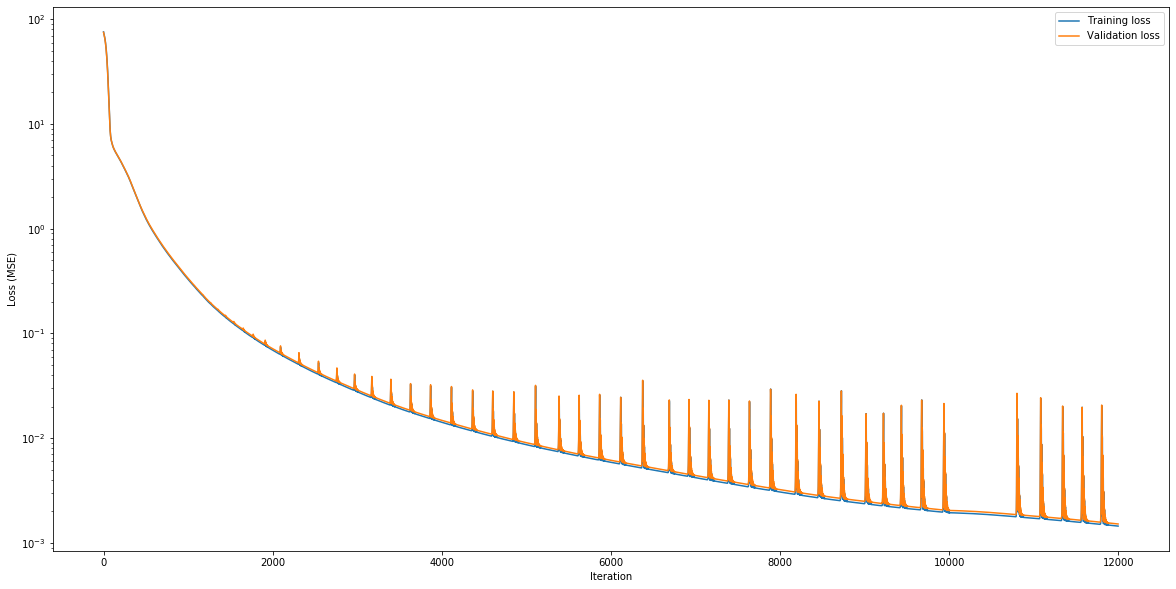

In [52]:
plt.figure(figsize=(20,10))
plt.semilogy(np_batched_loss_1,label='Training loss')
plt.semilogy(valid_loss,label='Validation loss')
plt.xlabel('Iteration')
plt.ylabel('Loss (MSE)')
plt.legend()


## Investigate performance of each band of emulator
To visulise performance of the trainied emulator, I will show the difference between real and emulated for each band.

In [53]:
net_params = get_params(opt_state)
predictions = net_apply(net_params,validation_batch_X)

In [54]:
validation_batch_X.shape

(41, 1200, 3)

In [55]:
validation_batch_X[0,:,:].shape

(1200, 3)

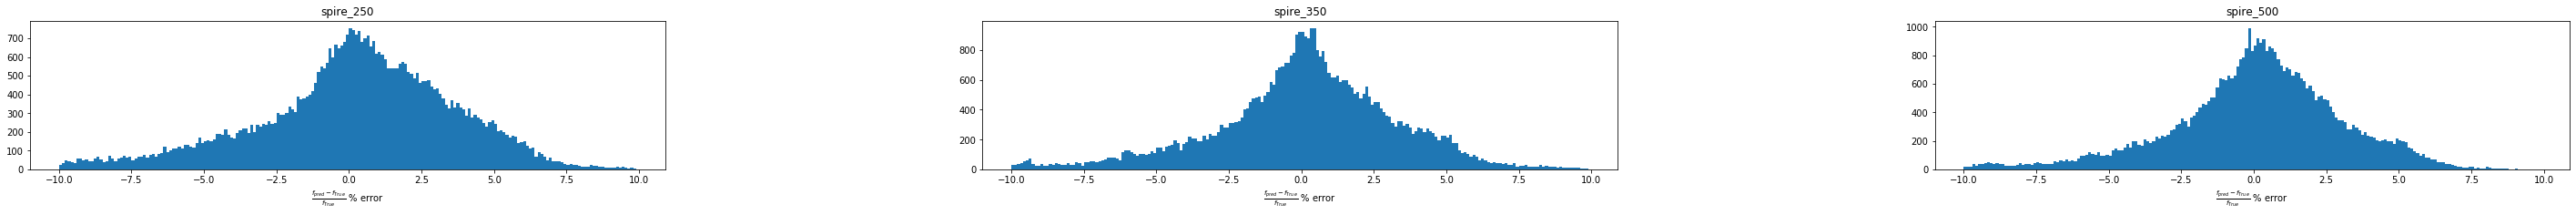

In [56]:
res=((np.exp(predictions)-np.exp(validation_batch_Y))/(np.exp(validation_batch_Y)))
fig,axes=plt.subplots(1,len(output_cols),figsize=(50,len(output_cols)))
for i in range(0,len(output_cols)):
    axes[i].hist(res[:,:,i].flatten()*100.0,np.arange(-10,10,0.1))
    axes[i].set_title(output_cols[i])
    axes[i].set_xlabel(r'$\frac{f_{pred} - f_{True}}{f_{True}} \ \%$ error')
plt.subplots_adjust(wspace=0.5)

## Save network
Having trained and validated network, I need to save the network and relevant functions

In [57]:
import cloudpickle


In [58]:
with open('CIGALE_emulator_20210330_log10sfr_uniformAGN_z.pkl', 'wb') as f:
    cloudpickle.dump({'net_init':net_init,'net_apply': net_apply,'params':net_params}, f)
    
net_init, net_apply

(<function jax.experimental.stax.serial.<locals>.init_fun(rng, input_shape)>,
 <function jax.experimental.stax.serial.<locals>.apply_fun(params, inputs, **kwargs)>)

## Does SED look right?

In [59]:
wave=np.array([250,350,500])

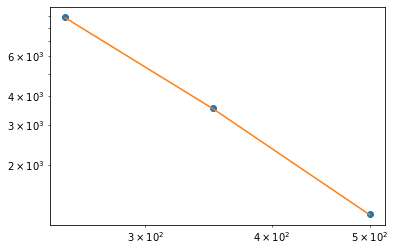

In [63]:
plt.loglog(wave,np.exp(net_apply(net_params,np.array([2.95, 0.801, 0.1]))),'o')
#plt.loglog(wave,10.0**net_apply(net_params,np.array([3.0,0.0,0.0])),'o')
plt.loglog(wave,dataset[(dataset['universe.redshift']==0.1) & (dataset['agn.fracAGN'] == 0.801) & (dataset['sfh.sfr']>900) & (dataset['sfh.sfr']<1100)][output_cols].values())

In [65]:
dataset[(dataset['universe.redshift']==0.1) & (dataset['agn.fracAGN'] == 0.801) & (dataset['sfh.sfr']>900) & (dataset['sfh.sfr']<1100)]

id,IRAC1,megacam_g,megacam_i,megacam_r,megacam_u,megacam_y,megacam_z,mips_24,spire_250,spire_350,spire_500,dust.luminosity,dust.mass,sfh.sfr,stellar.m_star,agn.fracAGN,attenuation.BC_to_ISM_factor,attenuation.bessell_b,attenuation.galex_fuv,attenuation.slope_BC,attenuation.slope_ISM,dust.qpah,dust.umin,sfh.age,sfh.burst_age,sfh.f_burst,sfh.tau_main,universe.redshift,log10_sfh.sfr,log10_universe.redshift,logit_agnfrac
,,,,,,,,,,,,,,,,,,mag,mag,mag,,,,Myr,,,,,,,
int64,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float32,float64,float64
2699,3561.7131,0.81075984,2.373399,1.5528784,0.25492316,2.4790812,3.5117917,12396.599,8839.021,3535.3625,1214.4366,8037312500000.0,4314639400.0,904.5928,175056060000.0,0.801,0.5,4.376290746740257,9.392077535240679,-0.7,-0.7,1.12,10.0,1000.0,50.0,0.1,3000.0,0.1,2.956453,-1.0,1.3925561223438672
